# Visualizing the SpaceX Tesla Roadster trip to Mars

In [1]:
# Temporary hack, see https://github.com/poliastro/poliastro/issues/281
from IPython.display import HTML
HTML('<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>')

In [2]:
from astropy.time import Time

from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter, plot

EPOCH = Time("2018-02-18 12:00:00", scale="tdb")

In [3]:
from astroquery.jplhorizons import conf
conf.horizons_server = 'https://ssd.jpl.nasa.gov/horizons_batch.cgi'

from astroquery.jplhorizons import Horizons

from astropy.coordinates import ICRS, CartesianRepresentation, CartesianDifferential
from poliastro.frames import HeliocentricEclipticJ2000

def get_roadster_orbit(epoch):
    roadster = Horizons(
        id="SpaceX Roadster", location="500@10", epochs=[epoch.jd], id_type="majorbody"
    ).elements()

    # Create Orbit object to do conversions
    roadster_eclip = Orbit.from_classical(
        Sun,
        roadster['a'][0] * u.au,
        roadster['e'][0] * u.one,
        roadster['incl'][0] * u.deg,
        roadster['Omega'][0] * u.deg,
        roadster['w'][0] * u.deg,
        roadster['nu'][0] * u.deg,
        epoch
    )

    # Convert to ICRS
    roadster_eclip_coords = HeliocentricEclipticJ2000(
        x=roadster_eclip.r[0], y=roadster_eclip.r[1], z=roadster_eclip.r[2],
        v_x=roadster_eclip.v[0], v_y=roadster_eclip.v[1], v_z=roadster_eclip.v[2],
        representation=CartesianRepresentation,
        differential_type=CartesianDifferential,
        obstime=epoch
    )

    roadster_icrs_coords = roadster_eclip_coords.transform_to(ICRS)
    roadster_icrs_coords.representation = CartesianRepresentation

    # Create final orbit
    roadster_icrs = Orbit.from_vectors(
        Sun,
        r=[roadster_icrs_coords.x, roadster_icrs_coords.y, roadster_icrs_coords.z] * u.km,
        v=[roadster_icrs_coords.v_x, roadster_icrs_coords.v_y, roadster_icrs_coords.v_z] * (u.km / u.s),
        epoch=epoch
    )

    return roadster_icrs

In [4]:
roadster = get_roadster_orbit(EPOCH)
roadster

1 x 2 AU x 24.2 deg orbit around Sun (☉)

In [5]:
from poliastro.plotting import plot_solar_system

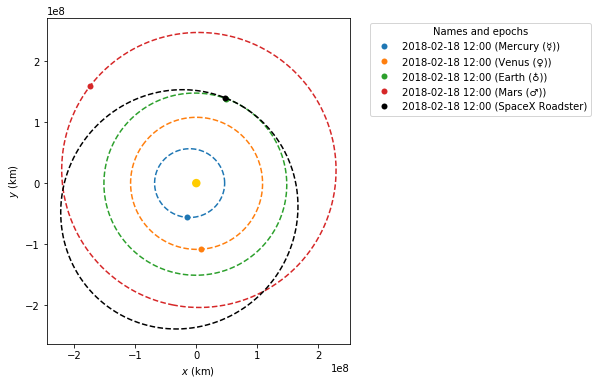

In [6]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot(roadster, label="SpaceX Roadster", color='k');

In [7]:
from poliastro.plotting import OrbitPlotter3D

from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

In [8]:
frame = OrbitPlotter3D()

frame.plot(Orbit.from_body_ephem(Earth, EPOCH), label=Earth)
frame.plot(Orbit.from_body_ephem(Mars, EPOCH), label=Mars)
frame.plot(roadster, label="SpaceX Roadster", color='black')

frame.set_view(30 * u.deg, -100 * u.deg, 2 * u.km)
frame.show()